In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os

# Load

In [2]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

,mouse,date,area,num
0,1350,211222_caiman,V1,2.0


In [111]:
root_path = 'C:/Users/ll357/Documents/inter/'
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # subtract baseline???
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']


# split side A/B bootstrap

In [112]:
ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]
dfof_ad_sideA = np.empty((ncell, nstim))
dfof_ad_sideB = np.empty((ncell, nstim))
dfof_tg_sideA = np.empty((ncell, nstim))
dfof_tg_sideB = np.empty((ncell, nstim))

for icell in np.arange(ncell):
    for istim in np.arange(nstim):
        ntrial_cond = dfof_ad_trial[icell,istim].shape[0]

        idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
        dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
        dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

        idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
        dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
        dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7)
adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)

In [113]:
def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10):
    df_th = df.copy()
    df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

In [117]:
_, _, _, df = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
df_th_sideA, mag_mean_sideA, _, _, _ = threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10)

_, _, _, df = df_adp_mag(adp_sideA, dfof_ad_sideB, dfof_tg_sideB)
df_th_sideB, mag_mean_sideB, _, _, _ = threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10)

corr_pearson, p_pearson = stats.pearsonr(mag_mean_sideA, mag_mean_sideB)
corr_spearman, _ = stats.spearmanr(mag_mean_sideA, mag_mean_sideB) # spearman p is only probably reasonable for datasets larger than 500 or so
print(corr_pearson, p_pearson)

0.0967743600958233 0.6109422511037361


<AxesSubplot:ylabel='Frequency'>

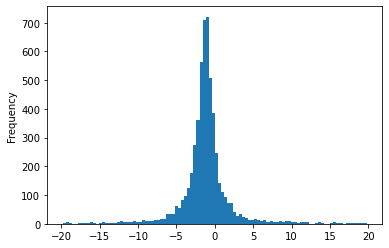

In [115]:
df_th_sideA.mag.plot(kind='hist', bins=100)